<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import skimage
from skimage import data
from skimage import io
from skimage.io import imread_collection
import cv2
import seaborn as sns
import scipy.stats as sc
import os
from skimage import img_as_ubyte
from skimage import feature

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import mahotas
import joblib

In [4]:
def gray_to_rgb(image):
    if len(image.shape) == 2:
        return skimage.color.gray2rgb(image)
    else:
        return image


def read_organize_data(file_path):
    #Fill this function out, should return a dataframe with picture object, and correct encoding
    label_list = next(os.walk(file_path))[1]
    label_list.sort()
    label_dict = {}
    for i in range(20):
        label_dict[i] = label_list[i]
    labels = list(label_dict.values())
    return_db = pd.DataFrame(columns = ['Pictures', 'Label','Encoding', 'File_Path'])
    for enc, label in label_dict.items():
        path = os.path.join(os.getcwd(),file_path + '/' + label)
        file_path_list = [path + '/' + x for x in os.listdir(path)]
        sub_db = pd.DataFrame()
        sub_db['Pictures'] = list(imread_collection(file_path_list))
        sub_db['Label'] = label
        sub_db['Encoding'] = enc
        sub_db['File_Path'] = file_path_list
        return_db = pd.concat([return_db, sub_db])
    return_db = return_db.reset_index()
    return_db['Pictures'] = return_db['Pictures'].apply(gray_to_rgb)
    return return_db
    

In [32]:
starting_data = read_organize_data('20_categories_training/20_categories_training')
starting_data.head()

,index,Pictures,Label,Encoding,File_Path
0,0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...
1,1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...
2,2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...
3,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...
4,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...


### Small Sampler function

In [6]:
def cat_sample(df, n = 5):
    return_df = pd.DataFrame()
    for cat in df['Label'].unique():
        sub_df = df[df['Label'] == cat]
        samp_df = sub_df.sample(n)
        return_df = pd.concat([return_df, samp_df])
    return return_df

In [7]:
small_df = cat_sample(starting_data)
len(small_df)

100

## Scalar feature functions

In [8]:

def img_size(image):
    return image.size
# Returns the pixel size of the image
def img_red_ch(image):
    if len(image.shape) == 2:
        return 0
    else:
        return image[:,:,0].mean()

def img_red_std(image):
    if len(image.shape) == 2:
        return 0
    else:
        return image[:,:,0].std()

def img_red_skew(image):
    return sc.skew(image[:,:,0].ravel(), nan_policy = 'omit')

def img_red_kurt(image):
    return sc.kurtosis(image[:,:,0].ravel(), nan_policy = 'omit')
    
def img_green_ch(image):
    if len(image.shape) == 2:
        return 0
    else:
        return image[:,:,1].mean()

def img_green_std(image):
    if len(image.shape) == 2:
        return 0
    else:
        return image[:,:,1].std()

def img_green_skew(image):
    return sc.skew(image[:,:,1].ravel(), nan_policy = 'omit')

def img_green_kurt(image):
    return sc.kurtosis(image[:,:,1].ravel(), nan_policy = 'omit')


def img_blue_ch(image):
    if len(image.shape) == 2:
        return 0
    else:
        return image[:,:,2].mean()
    
    
def img_blue_std(image):
    if len(image.shape) == 2:
        return 0
    else:
        return image[:,:,2].std()

def img_blue_skew(image):
    return sc.skew(image[:,:,2].ravel(), nan_policy = 'omit')

def img_blue_kurt(image):
    return sc.kurtosis(image[:,:,2].ravel(), nan_policy = 'omit')

# Returns the average of the red-channel pictures for the images
def img_asp(image):
    return image.shape[0]/image.shape[1]
#Returns the aspect ratio of the image



# Average gray intensity

def img_gray_int(image):
    gray = skimage.color.rgb2gray(image)
    return gray.mean()

def img_gray_std(image):
    gray = skimage.color.rgb2gray(image)
    return gray.std()

def img_gray_skew(image):
    gray = skimage.color.rgb2gray(image)
    return sc.skew(gray.ravel(), nan_policy = 'omit')

def img_gray_kurt(image):
    gray = skimage.color.rgb2gray(image)
    return sc.kurtosis(gray.ravel(), nan_policy = 'omit')

## Advanced feature functions 

In [41]:
def short_side_resize(image, length=256):
    """
    resize the image to a fixed short side length
    """
    height, width, _ = image.shape
    if height < width:
        ratio = length / height
    else:
        ratio = length / width
    new_height = int(height * ratio)
    new_width = int(width * ratio)
    return skimage.transform.resize(image, (new_height, new_width), mode='reflect', anti_aliasing=True)

def center_crop(image, length=224):
    """
    crop the center patch of the image with length * length
    """
    height, width, _ = image.shape
    cx, cy = height // 2, width // 2
    lx, ly = cx - length//2, cy - length//2
    hx, hy = length + lx, length + ly
    return image[lx:hx, ly:hy, :]

def feature_harris(image):
    """
    return amount of corners detected by Harris corner detector
    """
    image = center_crop(short_side_resize(image))
    gray = skimage.color.rgb2gray(image)
    gray = np.array(gray * 255, dtype=np.uint8)
    harris = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_corners = np.where(harris > 0)
    return len(harris_corners[0]) / harris.size

def feature_avg_y(image):
    """
    return mean value of luminance Y) 
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 0].mean()

def feature_avg_cb(image):
    """
    return mean value of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 1].mean()

def feature_avg_cr(image):
    """
    return mean value of red chroma component (Cr)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 2].mean()

def feature_std_y(image):
    """
    return standard derivation of luminance (Y)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 0].std()

def feature_std_cb(image):
    """
    return standard derivation of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 1].std()

def feature_std_cr(image):
    """
    return standard derivation of red chroma component (Cr)
    """
    image = skimage.color.rgb2ycbcr(image)
    return image[:, :, 2].std()

def feature_avg_hog(image):
    """
    return mean value of Histogram of Oriented Gradients (HOG)
    """
    return skimage.feature.hog(gray_to_rgb(image)).mean()

def feature_std_hog(image):
    """
    return standard derivation of Histogram of Oriented Gradients (HOG)
    """
    return skimage.feature.hog(gray_to_rgb(image)).std()


In [9]:
def fd_hu_moments(image):
    gray = skimage.color.rgb2gray(image)
    feature = cv2.HuMoments(cv2.moments(gray)).flatten()
    return feature

def fd_haralick(image):    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [10]:
def fd_haralick(image):    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick
fd_haralick(img)

NameError: name 'img' is not defined

 We expect all external sources sited, and significant indication of EDA. 

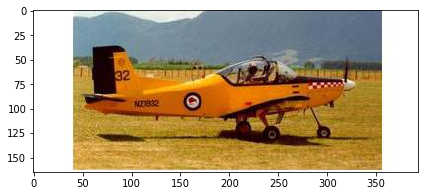

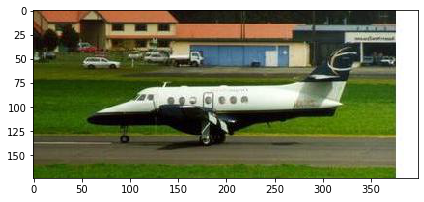

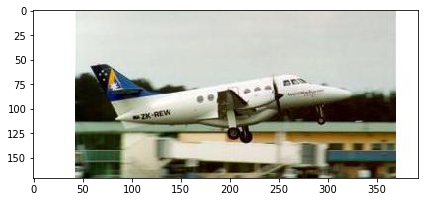

In [6]:
skimage.io.imshow(starting_data.loc[0,'Pictures'])
plt.show()
io.imshow(starting_data.loc[1,'Pictures'])
plt.show()
io.imshow(starting_data.loc[2,'Pictures'])
plt.show()

## Harris

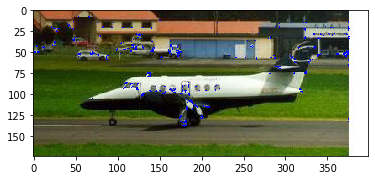

In [7]:
img = starting_data.loc[1,'Pictures'].copy()
gr = skimage.color.rgb2grey(img)
gr = np.float32(gr)
dst = cv2.cornerHarris(gr,2,3, 0.04)
img[dst>0.01*dst.max()]=[0,0,255]
#cv2.imshow('dst',img)

plt.imshow(img)

In [53]:
img.shape

(174, 399, 3)

## SHin tomasi

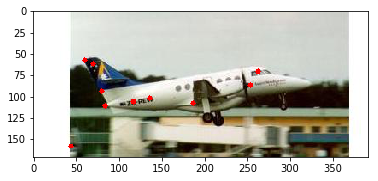

10

In [64]:
img = starting_data.loc[2,'Pictures'].copy()
gray = skimage.color.rgb2grey(img)
gray = np.float32(gray)
corners = cv2.goodFeaturesToTrack(gray,10,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)

plt.imshow(img),plt.show()
len(corners)

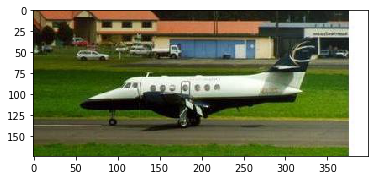

In [57]:
img = starting_data.loc[1,'Pictures']
plt.imshow(img)

Original features

In [33]:
starting_data['image_size'] = starting_data['Pictures'].apply(img_size)
starting_data['red_ch_intensity'] = starting_data['Pictures'].apply(img_red_ch)
starting_data['green_ch_intensity'] = starting_data['Pictures'].apply(img_green_ch)
starting_data['blue_ch_intensity'] = starting_data['Pictures'].apply(img_blue_ch)
starting_data['gray_intensity'] = starting_data['Pictures'].apply(img_gray_int)
starting_data['aspect_ratio'] = starting_data['Pictures'].apply(img_asp)
starting_data['red_ch_std'] = starting_data['Pictures'].apply(img_red_std)
starting_data['green_ch_std'] = starting_data['Pictures'].apply(img_green_std)
starting_data['blue_ch_std'] = starting_data['Pictures'].apply(img_blue_std)
starting_data['gray_std'] = starting_data['Pictures'].apply(img_gray_std)
starting_data['red_ch_skew'] = starting_data['Pictures'].apply(img_red_skew)
starting_data['green_ch_skew'] = starting_data['Pictures'].apply(img_green_skew)
starting_data['blue_ch_skew'] = starting_data['Pictures'].apply(img_blue_skew)
starting_data['gray_skew'] = starting_data['Pictures'].apply(img_gray_skew)
starting_data['red_ch_kurt'] = starting_data['Pictures'].apply(img_red_kurt)
starting_data['green_ch_kurt'] = starting_data['Pictures'].apply(img_green_kurt)
starting_data['blue_ch_kurt'] = starting_data['Pictures'].apply(img_blue_kurt)
starting_data['gray_kurt'] = starting_data['Pictures'].apply(img_gray_kurt)

starting_data['low_contrast'] = starting_data['Pictures'].apply(lambda x: skimage.exposure.is_low_contrast(x,fraction_threshold=0.4))
starting_data['low_contrast'] = starting_data['low_contrast'].astype(int)
starting_data.head()

,index,Pictures,Label,Encoding,File_Path,image_size,red_ch_intensity,green_ch_intensity,blue_ch_intensity,gray_intensity,...,gray_std,red_ch_skew,green_ch_skew,blue_ch_skew,gray_skew,red_ch_kurt,green_ch_kurt,blue_ch_kurt,gray_kurt,low_contrast
0,0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,194535,170.123787,147.788681,111.753798,0.587987,...,0.258755,-0.259019,0.106323,0.441830,0.157973,-0.904141,-0.344178,-1.202180,-0.348619,0
1,1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,208278,98.426973,104.499870,67.531631,0.394290,...,0.247674,0.961537,0.927138,1.355689,1.031927,-0.028547,0.506824,0.862590,0.574022,0
2,2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,201096,174.865318,175.592150,163.577814,0.684594,...,0.307039,-0.914682,-0.959822,-0.788366,-0.930180,-0.571888,-0.473785,-0.844127,-0.541991,0
3,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,221352,210.739822,189.280101,164.805242,0.753238,...,0.268585,-1.962853,-1.597588,-1.268777,-1.562897,3.212088,1.282528,0.636470,1.294783,0
4,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,166662,147.548565,155.967905,127.917054,0.596691,...,0.293273,-0.204144,-0.325232,-0.214351,-0.263015,-1.371266,-1.278711,-1.665865,-1.387016,0


New Features

In [44]:
starting_data["harris"] = starting_data["Pictures"].apply(feature_harris)
starting_data["avg_y"] = starting_data["Pictures"].apply(feature_avg_y)
starting_data["avg_cb"] = starting_data["Pictures"].apply(feature_avg_cb)
starting_data["avg_cr"] = starting_data["Pictures"].apply(feature_avg_cr)
starting_data["std_y"] = starting_data["Pictures"].apply(feature_std_y)
starting_data["std_cb"] = starting_data["Pictures"].apply(feature_std_cb)
starting_data["std_cr"] = starting_data["Pictures"].apply(feature_std_cr)
starting_data["avg_hog"] = starting_data["Pictures"].apply(feature_avg_hog)
starting_data["std_hog"] = starting_data["Pictures"].apply(feature_std_hog)

In [53]:
starting_data.head()

,index,Pictures,Label,Encoding,File_Path,image_size,red_ch_intensity,green_ch_intensity,blue_ch_intensity,gray_intensity,...,harris,dog,avg_y,avg_cb,avg_cr,std_y,std_cb,std_cr,avg_hog,std_hog
0,0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,194535,170.123787,147.788681,111.753798,0.587987,...,0.525590,0.146858,145.131762,108.862326,140.383809,56.089846,25.872970,18.981218,0.068713,0.085799
1,1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,208278,98.426973,104.499870,67.531631,0.394290,...,0.356684,0.132184,100.568091,112.663116,127.973235,54.617943,13.839343,10.310406,0.066466,0.089039
2,2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,201096,174.865318,175.592150,163.577814,0.684594,...,0.329022,0.079992,165.439754,122.830849,128.538917,67.318835,7.291308,5.276569,0.060532,0.091604
3,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,221352,210.739822,189.280101,164.805242,0.753238,...,0.490832,0.062046,181.672576,114.069423,139.173623,56.847182,6.279454,17.758453,0.074722,0.082233
4,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0,/Users/vikrant/Classes/DS 100/final_project/20...,166662,147.548565,155.967905,127.917054,0.596691,...,0.399195,0.116355,145.040576,116.927570,126.305695,64.984949,14.138249,4.954774,0.063918,0.089429


In [45]:
#starting_data['low_contrast'] = starting_data['Pictures'].apply(lambda x: skimage.exposure.is_low_contrast(x,fraction_threshold=0.4))
#starting_data['low_contrast'] = starting_data['low_contrast'].astype(int)
starting_data['low_contrast'].sum()

506

In [47]:
starting_data.shape

(1501, 34)

In [12]:
sub = starting_data[starting_data['low_contrast'] == 1]
sub['Label'].value_counts()

leopards        63
comet           55
gorilla         36
unicorn         35
dolphin         33
teddy-bear      25
kangaroo        23
penguin         22
porcupine       22
llama           22
blimp           21
bear            21
crab            20
killer-whale    20
goat            19
triceratops     19
giraffe         17
zebra           17
dog             16
Name: Label, dtype: int64

### Grayscale exception

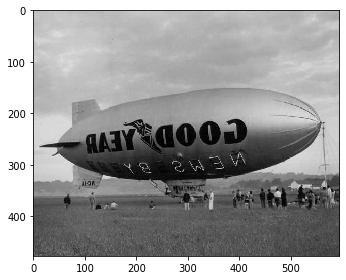

(477, 595, 3)

In [13]:
img = starting_data.loc[180,'Pictures'].copy()
io.imshow(img)
plt.show()
skimage.exposure.is_low_contrast(img)
img.shape

### Pixel Intensity Histograms

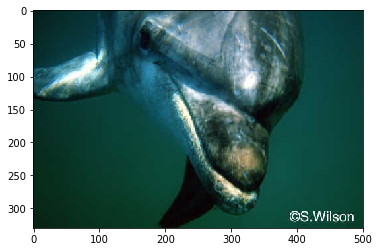

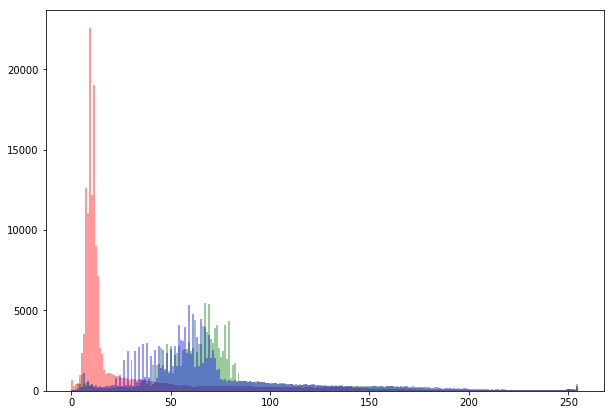

In [19]:
img = starting_data.loc[420,'Pictures'].copy()
gray = skimage.color.rgb2grey(img)
#histo = cv2.calcHist([img], )
plt.imshow(img)
plt.show()
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]
plt.figure(figsize = (10,7))
sns.distplot(red.ravel(), color='red', bins = 256, kde = False)
sns.distplot(green.ravel(), color='green', bins = 256, kde = False)
sns.distplot(blue.ravel(), color='blue', bins = 256, kde = False)
plt.show()

## Bag of Visual Words Functions

In [7]:
sift = cv2.xfeatures2d.SIFT_create()
def formatND(lis):
    print('Forming Vertical stack descriptor')
    vStack = np.array(lis[0])
    for remaining in lis[1:]:
        vStack = np.vstack((vStack, remaining))
    print('Formed Vertical Stack Descriptor')
    return vStack

def features(image, extractor = cv2.xfeatures2d.SIFT_create()):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = extractor.detectAndCompute(gray, None)
    return keypoints, descriptors

def cluster(descriptor_vstack, kmeans_obj):
    """
    cluster using KMeans algorithm, 
    """
    print('CLUSTERING...')
    kmeans_ret = kmeans_obj.fit_predict(descriptor_vstack)
    print('FINISHED CLUSTERING')
    return (kmeans_ret, kmeans_obj)

def developVocabulary(n_clusters, n_images, descriptor_list, kmeans_ret):

    """
    Each cluster denotes a particular visual word 
    Every image can be represeted as a combination of multiple 
    visual words. The best method is to generate a sparse histogram
    that contains the frequency of occurence of each visual word 
    Thus the vocabulary comprises of a set of histograms of encompassing
    all descriptions for all images
    """
    mega_histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
    old_count = 0
    print('Generating Vocabulary Histogram')
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    print("Vocabulary Histogram Generated")
    return mega_histogram

def plotHist(vocabulary, n_clusters):
    print("Plotting histogram")
    x_scalar = np.arange(n_clusters)
    y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(n_clusters)])
    print(y_scalar)
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()
    
def standardize(mega_histogram):
    """
    
    standardize is required to normalize the distribution
    wrt sample size and features. If not normalized, the classifier may become
    biased due to steep variances.
    """

    scale = StandardScaler().fit(mega_histogram)
    mega_histogram = scale.transform(mega_histogram)
    return mega_histogram



## Bag of Visual Words Implementation

Computing for airplanes
Number of Images = 80
Descriptor list length = 80
Computing for bear
Number of Images = 68
Descriptor list length = 148
Computing for blimp
Number of Images = 57
Descriptor list length = 205
Computing for comet
Number of Images = 81
Descriptor list length = 286
Computing for crab
Number of Images = 57
Descriptor list length = 343
Computing for dog
Number of Images = 68
Descriptor list length = 411
Computing for dolphin
Number of Images = 71
Descriptor list length = 482
Computing for giraffe
Number of Images = 56
Descriptor list length = 538
Computing for goat
Number of Images = 75
Descriptor list length = 613
Computing for gorilla
Number of Images = 141
Descriptor list length = 754
Computing for kangaroo
Number of Images = 55
Descriptor list length = 809
Computing for killer-whale
Number of Images = 61
Descriptor list length = 870
Computing for leopards
Number of Images = 127
Descriptor list length = 997
Computing for llama
Number of Images = 79
Descriptor list 

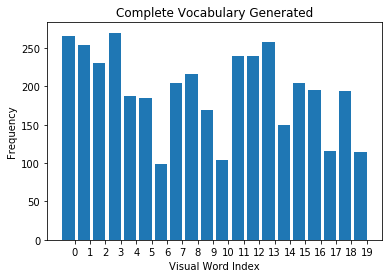

In [16]:
n_clusters = 20
kmeans = KMeans(n_clusters = n_clusters, n_jobs = 2)
sift = cv2.xfeatures2d.SIFT_create()

descriptor_list = []

for lbl in starting_data['Label'].unique():
    sub_df = starting_data[starting_data['Label'] == lbl]
    print(f'Computing for {lbl}')
    print(f'Number of Images = {len(sub_df)}')
    for img in sub_df['Pictures'].values:
        kp, des = features(img)
        descriptor_list.append(des)
    print(f'Descriptor list length = {len(descriptor_list)}')
    
descriptor_vstack = formatND(descriptor_list)
ret_kmeans, kmeans_pred = cluster(descriptor_vstack, kmeans)
histo = developVocabulary(n_clusters, len(starting_data), descriptor_list, ret_kmeans)
std_histo = standardize(histo)
plotHist(std_histo, n_clusters)

### Saving Stuff

In [31]:
!ls

20_Validation.zip          GradProject_NB3.ipynb
20_categories_training     GradProject_NB4.ipynb
20_categories_training.zip bag_of_words.csv
GradProject_NB1.ipynb      gradProject.pdf
GradProject_NB2.ipynb      kmeans_predictor.joblib


In [30]:
np.savetxt("bag_of_words.csv", std_histo, delimiter=",")
joblib.dump(kmeans_pred, 'kmeans_predictor.joblib')
#kmeans_predictor = joblib.load('kmeans_predictor.joblib')

['kmeans_predictor.joblib']

In [15]:
starting_data['Encoding'].value_counts()

9     141
12    127
14     99
3      81
0      80
13     79
8      75
6      71
5      68
1      68
15     67
16     67
18     65
19     64
17     63
11     61
4      57
2      57
7      56
10     55
Name: Encoding, dtype: int64

### Predicting cluster example

In [59]:
kmeans_pred.predict(descriptor_list[2][:])

array([ 6,  3, 13, 11, 11,  1,  3, 12,  0,  0,  1,  1,  2, 11,  2, 12, 11,
        7,  3,  0,  7,  3,  0, 11,  0, 11,  0, 11, 11, 13,  0,  0, 18, 16,
       14,  2,  2, 12,  6, 18,  3,  2, 11, 13,  1, 18,  2, 12, 10,  3,  4,
       10,  7,  9,  3,  0,  6, 10,  3, 10,  6, 14,  6,  7, 14,  6, 13,  2,
       12, 17,  2,  6, 12, 17,  0, 11, 15,  0,  5,  2, 11, 10,  0,  6, 18,
        1,  6,  6, 10, 10,  6,  0,  2,  6, 10, 11, 14, 13, 17, 13,  2, 16,
       10, 10, 16,  3,  1, 11,  9,  2, 16,  3,  2, 17,  7,  0,  0, 11, 11,
        3, 16, 12, 16, 11, 16, 16,  4, 16, 16, 14, 12,  3,  1, 14,  2,  8,
       16, 15, 16, 18, 14,  0, 18,  3, 18, 19, 16, 12, 14, 16, 10,  9,  2,
        2, 12,  2, 16,  2, 16, 16,  2, 13, 11, 19,  5, 14,  0,  9, 13, 13,
        7, 15,  2,  2,  5,  6, 15,  7, 11,  2, 12,  1, 13, 15, 12,  3, 12,
        2, 10,  5, 11, 12,  3,  3,  9,  6, 19,  9,  3, 13, 14,  2, 19,  2,
       13, 13,  3,  6,  6,  3, 10, 14, 18, 10, 18,  0,  6,  2,  8, 13, 11,
        4,  1, 14, 14, 14

In [63]:
len(std_histo[0])

20

### Loading Stuff

In [12]:
std_histo = np.loadtxt("bag_of_words.csv", delimiter=",")
kmeans_predictor = joblib.load('kmeans_predictor.joblib')

/anaconda3/envs/pred/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Stacking bag of words and simple features into one dataframe

In [57]:
std_histo.shape

(1501, 20)

In [54]:
starting_data.loc[:, 'image_size': 'std_hog'].values.shape

(1501, 29)

In [55]:
column_names = [f'bag_of_words_0{i}' if i < 10 else  f'bag_of_words_{i}' for i in range(1,21)]
bag_df = pd.DataFrame(std_histo, columns = column_names)

final_data = pd.concat([starting_data.loc[:, 'Encoding'], starting_data.loc[:, 'image_size': 'std_hog'], bag_df], axis = 1)
final_data

,Encoding,image_size,red_ch_intensity,green_ch_intensity,blue_ch_intensity,gray_intensity,aspect_ratio,red_ch_std,green_ch_std,blue_ch_std,...,bag_of_words_11,bag_of_words_12,bag_of_words_13,bag_of_words_14,bag_of_words_15,bag_of_words_16,bag_of_words_17,bag_of_words_18,bag_of_words_19,bag_of_words_20
0,0,194535,170.123787,147.788681,111.753798,0.587987,0.419847,64.391428,68.085443,89.914294,...,0.024414,-0.432951,-0.365699,-0.633952,-0.301662,-0.411993,-0.302897,-0.148665,-0.345383,-0.165070
1,0,208278,98.426973,104.499870,67.531631,0.394290,0.436090,67.497923,62.734611,72.463596,...,-0.155536,-0.444910,-0.420257,-0.451390,-0.088163,-0.369739,-0.291270,-0.201078,-0.233238,-0.165070
2,0,201096,174.865318,175.592150,163.577814,0.684594,0.436224,77.065435,78.290643,84.928914,...,-0.219803,-0.289450,-0.438444,-0.481817,-0.258962,-0.420444,-0.279643,-0.237767,-0.308001,-0.236039
3,0,221352,210.739822,189.280101,164.805242,0.753238,0.458853,55.293247,74.486619,70.417988,...,-0.226230,-0.492744,-0.438444,-0.542671,-0.372828,-0.386641,-0.337778,-0.248249,-0.289311,-0.250232
4,0,166662,147.548565,155.967905,127.917054,0.596691,0.357868,74.451166,73.357112,95.621769,...,-0.245510,-0.432951,-0.511188,-0.466603,-0.323012,-0.411993,-0.378472,-0.195837,-0.370304,-0.221845
5,0,181488,203.017158,189.096668,165.905167,0.746599,0.381910,57.346861,63.754391,61.815093,...,-0.271218,-0.444910,-0.474816,-0.405749,-0.344361,-0.335936,-0.361032,-0.243008,-0.364074,-0.259695
6,0,195816,183.355727,176.750337,149.151581,0.690840,0.412060,56.406650,64.039966,79.648356,...,-0.168389,-0.349242,-0.429351,-0.512244,-0.266079,-0.361289,-0.361032,-0.190595,-0.370304,-0.188726
7,0,245367,96.754551,89.420069,57.288608,0.347694,0.484185,53.745931,56.804103,62.287883,...,-0.136255,-0.217699,-0.120185,-0.192759,-0.024114,-0.319035,-0.140120,-0.143424,-0.195857,-0.113026
8,0,171936,132.558557,136.305259,106.687081,0.523034,0.361809,71.915393,72.193653,87.162401,...,-0.296925,-0.420993,-0.483909,-0.527457,-0.323012,-0.437346,-0.366845,-0.227284,-0.339153,-0.250232
9,0,193914,150.511232,150.789752,125.096600,0.583836,0.406015,80.127436,81.237997,104.381384,...,-0.232657,-0.373159,-0.374792,-0.451390,-0.266079,-0.352838,-0.331964,-0.232525,-0.326692,-0.188726


In [29]:
final_data.to_csv('training_data.csv')

In [58]:
final_data.to_csv('new_training_data.csv')

## Fitting Logistic Check

In [13]:

x = std_histo
y = starting_data['Encoding'].values
y=y.astype('int')
logisticRegr = LogisticRegression(penalty = 'l2', multi_class = 'multinomial', solver = 'lbfgs', max_iter = 200)
logisticRegr.fit(x, y)

y_pred = logisticRegr.predict(x)
accuracy_score(y_pred, y)

0.3637574950033311

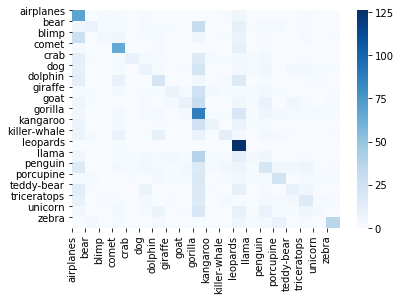

In [14]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y, y_pred, labels = starting_data['Encoding'].unique().astype(int))
sns.heatmap(conf, cmap = 'Blues')
plt.xticks(starting_data['Encoding'].unique().astype(int), starting_data['Label'].unique(), rotation = 90)
plt.yticks(starting_data['Encoding'].unique().astype(int), starting_data['Label'].unique())
plt.show()

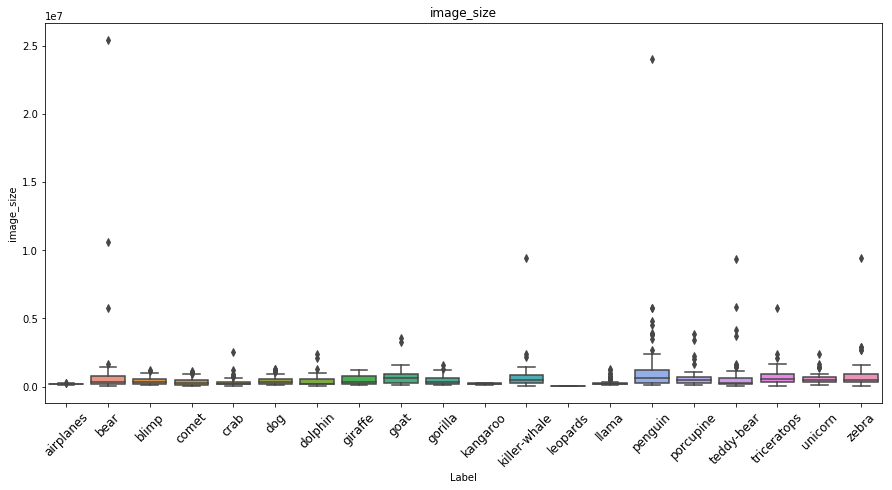

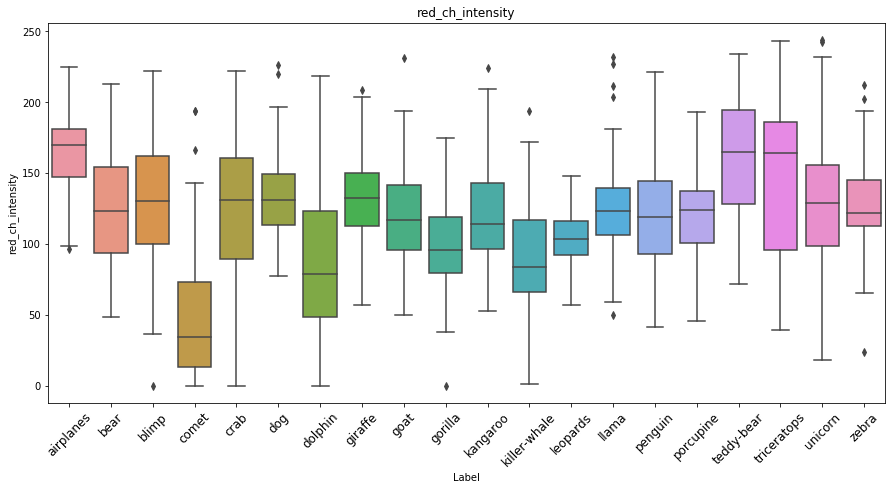

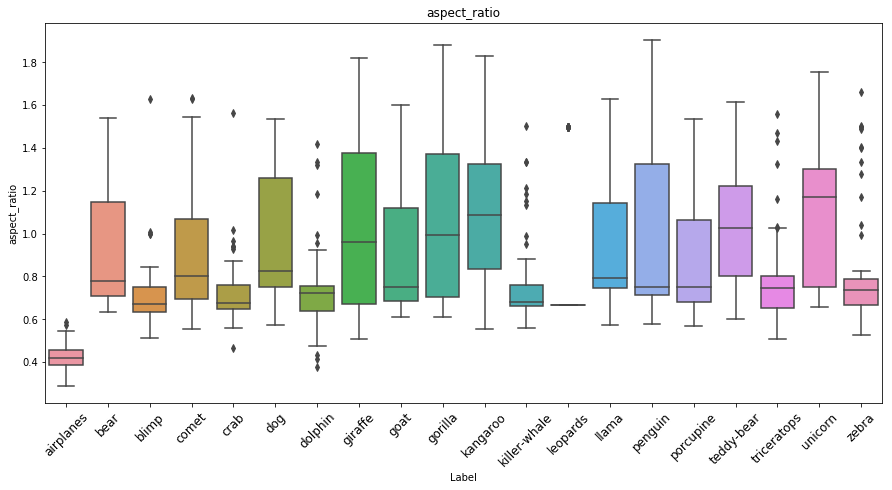

In [12]:
for ft in ['image_size', 'red_ch_intensity', 'aspect_ratio']:
    plt.figure(figsize = (15,7))
    sns.boxplot(x = 'Label', y = ft, data = starting_data)
    plt.xticks(rotation = 45, size = 'large')
    plt.title(ft)
    plt.show()

<h4> Sources </h4>

<h4> DataFrame Creation </h4>

In [2]:
def feature_frame(df):
    return df
    #Returns data-frame with all the features now inside, and calculated


In [3]:
feature_frame(data_from_nb1)

NameError: name 'starting_data' is not defined